In [1]:
# import libraries 

# the usual suspects
import numpy as np
import pandas as pd
import os
import copy
import warnings
warnings.filterwarnings('ignore')


# plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy.signal import savgol_filter

# mazelab
from mazelab import BaseMaze, Object, BaseEnv, VonNeumannMotion
from mazelab import DeepMindColor as color

# gym
import gym
from gym.spaces import Box
from gym.spaces import Discrete




## Create the Environment - Tolman's Maze 

The maze has been adapted from the following paper by Edward Tolman 

> Tolman, Edward C. "Cognitive maps in rats and men." Psychological review 55.4 (1948): 189.

This implementation of the maze is a full-fledged environment compatible with open-AI gym and by extension a plethora of open source RL libraries. It is created using mazelab - https://github.com/zuoxingdong/mazelab.git

There were some issues with image rendering that I had to fix. The fixed version of the library can be found on my fork - https://github.com/rrrajjjj/mazelab.git

<img src="tolman_maze.png" width=400 height=400/>


In [2]:
# load the maze array
with open("tolman_maze.npy", "rb") as f:
    x = np.load(f)
    
# define start and goal states
start_idx = [[13, 2]]
goal_idx = [[13, 11]]

# environment ID to register the environment with gym
env_id = "TolmanMaze-v0"

### Make Environment

In [3]:
class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal
    
class Env(BaseEnv):
    def __init__(self, reward = 1):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        self.reward = reward
        self.final_reward = 0
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = self.reward
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = 0
            done = False
        self.final_reward += reward
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        if (nonnegative and within_edge):
            passable = not self.maze.to_impassable()[position[0]][position[1]]
        else:
            return False
        
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()
    
        

In [4]:
# register the environment with gym
gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=200)


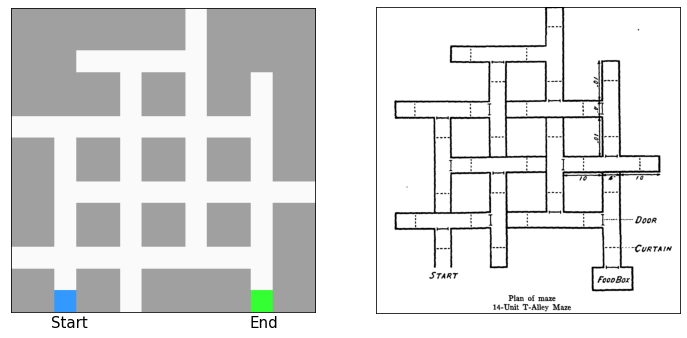

In [5]:
# let's take a look at our maze 
env = gym.make(env_id)
env.reset()
img = env.render("rgb_array")
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.text(65, 525,  "Start", fontsize=15)
plt.text(392, 525,  "End", fontsize=15)
plt.subplot(1, 2, 2)
plt.imshow(plt.imread("tolman_maze.png"))
plt.xticks([])
plt.yticks([])

plt.show()

## Testing the Environment with Stable Baselines

### Some housekeeping functions

In [6]:
# function to run an episode 
def run_episode(bRender=False, model=None):
    done = False
    obs = env.reset()
    sum_reward = 0
    while not done:
        if model == None:
            action = env.action_space.sample()
        else:
            action, _ = model.predict(obs, deterministic=True)
            
        obs, rew, done, _ = env.step(action)
        sum_reward += rew
        if bRender:
            env.render("rgb_array")
        #print("obs",obs,"rew",rew, "done", done)
    print("Episode ended sum_reward =",sum_reward)
    return rew


In [7]:
# function to make a video for an episode given a model 
def make_video(env, model, filename, fps = 6, n_steps = 100):
    """
    Filename has to be with a .gif extension. 
    Filename format - Model_TrainingTrials.gif
    Example - PPO_1000.gif (Episode run with a PPO model trained for 1000 iterations)
    """
    model_name = filename.split("/")[-2]
    obs = env.reset()
    fig, ax = plt.subplots(figsize=(6,6))
    plt.axis('off')
    frames = []
    tot_reward = 0
    
    for step in range(n_steps):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        tot_reward += reward
        frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
        if done:
            break
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box 
    anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
    
    if not os.path.isdir(f"videos/{model_name}"):
        os.makedirs(f"videos/{model_name}")
    anim.save(filename,dpi=150)
    plt.close()


### Training a model and generating videos for results

In [8]:
%%capture                                       
# training a PPO model
from stable_baselines3 import PPO
model = PPO("MlpPolicy", env, verbose=0)
for iteration in range(1, 6):
    # train for 5000 iterations
    model.learn(total_timesteps=5000)
    make_video(env, model, filename = f"videos/PPO/{iteration*5000}.gif")
env.close()


### After 5000 iterations of training $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$  After 25000 iterations of training

<img src="videos/PPO/5000.gif" width="250" align="left">
<img src="videos/PPO/25000.gif" width="250" align="centre">


### Yayy!🥳 The environment seems to be working!

# Go-Explore

In [9]:
alpha = 0.01
eps = 0.0001
weights = {"times_seen":1, "times_chosen":1, "value":10}

In [10]:
# state related helper functions 
def state_id(idx):
    # each state is indexed by a unique integer 
    return idx[0]*14 + idx[1]

def state_score(state_id, archive):
    state = archive[state_id]
    score = weights["times_seen"]/(state["times_seen"]+eps) +\
            weights["times_chosen"]/(state["times_chosen"]+eps) +\
            weights["value"]*state["value"]
    return score

def choose_goal(archive):
    states = [s for s in archive.keys()]
    scores = np.array([state_score(state, archive) for state in states])
    probs = scores / scores.sum()
    goal = np.random.choice(states, p = probs)
    return goal

def archive_state(archive, state, reward, trajectory):
    if state not in archive:
        # add state to archive
        archive[state] = {"times_seen":1, "times_chosen":0, "value":alpha*reward, "trajectory":trajectory.copy()}
    else:
        # update times seen
        archive[state]["times_seen"]+=1
        # update value
        error = reward - archive[state]["value"] 
        archive[state]["value"] += error*alpha
        # update trajectory
        if len(archive[state]["trajectory"]) >= len(trajectory):
            archive[state]["trajectory"] = trajectory.copy()
    return archive  

In [11]:
def exploration_episode(archive):
    episode_length = 0
    # reset environment
    env.reset()
    done = False
    current_state = state_id(env.maze.objects.agent.positions[0])
    # choose a goal state from the archive 
    goal = choose_goal(archive)
    archive[goal]["times_chosen"] += 1
    goal_trajectory = archive[goal]["trajectory"].copy()
    new_trajectory = []
    
    if np.random.random() < 0.95:
        # return to that state by following the trajectory (90% of the times)
        while (goal_trajectory and not done):
            action = goal_trajectory.pop(0) 
            # execute action
            _, _, done, _ = env.step(action)
            # reward only if done
            reward = R*done
            # update current state and put into archive 
            next_state = state_id(env.maze.objects.agent.positions[0])
            if next_state != current_state:
                # update new trajectory
                new_trajectory.append(action) 
                # update archive
                archive = archive_state(archive, next_state, reward, new_trajectory)
                # update the next_state
                current_state = next_state
                # update episode length
                episode_length+=1
    
    if not done:
        # explore for 100 steps 
        for i in range(100):
            action = env.action_space.sample()
            # execute action
            _, _, done, _ = env.step(action)
            # reward only if done
            reward = R*done
            # update current state and put into archive 
            next_state = state_id(env.maze.objects.agent.positions[0])
            if next_state != current_state:
                # update new trajectory
                new_trajectory.append(action) 
                # update archive 
                archive = archive_state(archive, next_state, reward, new_trajectory)
                # update the current state
                current_state = next_state
                # update episode length
                episode_length+=1
                
    return archive, episode_length


# The Tolman Experiment

## Group-1: Rewarded in all trials

In [12]:
# initialise archive 
archive = {}

# add initial state to the archive 
env.reset()
current_state = state_id(env.maze.objects.agent.positions[0])
archive[current_state] = {"times_seen":1, "times_chosen":0, "value":0, "trajectory":[]}



In [13]:
# Reward throughout 
R = 1
# initialise log
group1_log = []

# run trials
for i in range(5000):
    archive, episode_length = exploration_episode(archive)
    group1_log.append(episode_length)


## Group-2: Reward introduced mid-way

In [14]:
# initialise archive 
archive = {}

# add initial state to the archive 
env.reset()
current_state = state_id(env.maze.objects.agent.positions[0])
archive[current_state] = {"times_seen":1, "times_chosen":0, "value":0, "trajectory":[]}


In [15]:
# set reward in the environment to 0
R = 0
# initialise log
group2_log = []

# run half the trials 
for i in range(2500):
    archive, episode_length = exploration_episode(archive)
    group2_log.append(episode_length)

# reintroduce the reward
R = 1

# run the rest of the trials
for i in range(2500):
    archive, episode_length = exploration_episode(archive)
    group2_log.append(episode_length)


## Group-3: No Rewards

In [16]:
# initialise archive 
archive = {}

# add initial state to the archive 
env.reset()
current_state = state_id(env.maze.objects.agent.positions[0])
archive[current_state] = {"times_seen":1, "times_chosen":0, "value":0, "trajectory":[]}


In [17]:
# set reward in the environment to 0
R = 0

# run the trials 
group3_log = []
for i in range(5000):
    archive, episode_length = exploration_episode(archive)
    group3_log.append(episode_length)


## Moment of Truth - Did this work as expected?

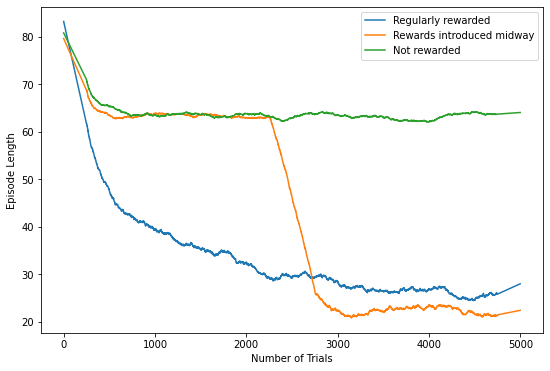

In [24]:
plt.figure(figsize=(9, 6))
plt.plot(savgol_filter(group1_log, 501, 1), label="Regularly rewarded")
plt.plot(savgol_filter(group2_log, 501, 1), label="Rewards introduced midway")
plt.plot(savgol_filter(group3_log, 501, 1), label="Not rewarded")
plt.ylabel("Episode Length")
plt.xlabel("Number of Trials")
plt.legend()
plt.show()

## How cool is that ?!!

### Cool enough to warrant an answer to a rhetorical question!